<a href="https://colab.research.google.com/github/ClaraMikaelly-ifpi/Trabalho-Final-IA/blob/main/RedeNeuralArroz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/trabalhoIA/dataset'

#aluna: Clara Mikaelly Veras  da Costa

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/trabalhoIA/dataset.zip'
extract_path = '/content/drive/MyDrive/trabalhoIA/dataset'

#descompactar
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

print("Extração feita")

Extração feita


In [23]:
import os
import shutil
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


In [24]:


# Diretórios originais
grao_quebrado_orig = '/content/drive/MyDrive/trabalhoFinal/dataset/grao_quebrado'
graos_inteiros_orig = '/content/drive/MyDrive/trabalhoFinal/dataset/graos_inteiros'

# Diretórios de destino
base_split_dir = '/content/drive/MyDrive/trabalhoFinal/dataset_split'
train_dir = os.path.join(base_split_dir, 'train')
val_dir = os.path.join(base_split_dir, 'val')
test_dir = os.path.join(base_split_dir, 'test')

# Subpastas para cada classe
classes = {
    'grao_quebrado': grao_quebrado_orig,
    'graos_inteiros': graos_inteiros_orig
}

# Criar diretórios base
for split in [train_dir, val_dir, test_dir]:
    for class_name in classes:
        os.makedirs(os.path.join(split, class_name), exist_ok=True)

# Função para copiar TODOS os arquivos para teste (100%)
def copy_all_to_test(original_dir, test_target_dir):
    for root, _, files in os.walk(original_dir):
        for f in files:
            src_path = os.path.join(root, f)
            relative_path = os.path.relpath(src_path, original_dir)
            dest_path = os.path.join(test_target_dir, relative_path)
            os.makedirs(os.path.dirname(dest_path), exist_ok=True)
            shutil.copy(src_path, dest_path)

# Função para dividir em treino e validação
def split_train_val(original_dir, train_target_dir, val_target_dir, train_ratio=0.8):
    all_files = []
    for root, _, files in os.walk(original_dir):
        for f in files:
            all_files.append(os.path.join(root, f))

    random.shuffle(all_files)

    train_end = int(len(all_files) * train_ratio)
    train_files = all_files[:train_end]
    val_files = all_files[train_end:]

    print(f"{original_dir} -> treino: {len(train_files)}, validação: {len(val_files)}")

    for files, target_dir in [(train_files, train_target_dir), (val_files, val_target_dir)]:
        for src_path in files:
            relative_path = os.path.relpath(src_path, original_dir)
            dest_path = os.path.join(target_dir, relative_path)
            os.makedirs(os.path.dirname(dest_path), exist_ok=True)
            shutil.copy(src_path, dest_path)

# Processar cada classe
for class_name, orig_path in classes.items():
    # Caminhos de destino para treino, val e teste
    train_target = os.path.join(train_dir, class_name)
    val_target = os.path.join(val_dir, class_name)
    test_target = os.path.join(test_dir, class_name)

    # Copiar todos os arquivos para teste
    copy_all_to_test(orig_path, test_target)

    # Dividir para treino e validação
    split_train_val(orig_path, train_target, val_target)

print("\n✅ Divisão concluída: treino (80%), validação (20%), teste (100%) dos originais.")


/content/drive/MyDrive/trabalhoFinal/dataset/grao_quebrado -> treino: 59, validação: 15
/content/drive/MyDrive/trabalhoFinal/dataset/graos_inteiros -> treino: 94, validação: 24

✅ Divisão concluída: treino (80%), validação (20%), teste (100%) dos originais.


In [37]:
# Diretórios ajustados
train_dir = '/content/drive/MyDrive/trabalhoFinal/dataset_split/train'
val_dir = '/content/drive/MyDrive/trabalhoFinal/dataset_split/val'
test_dir = '/content/drive/MyDrive/trabalhoFinal/dataset_split/test'

# Aumento de dados para o treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.6, 1.4),
    fill_mode='nearest'
)

# Apenas normalização para validação e teste
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Gerador de imagens para treino
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

# Gerador para validação
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

# Gerador para teste (dados 100% originais)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

# Cálculo de pesos de classe com base no conjunto de treino
classes = np.array([0, 1])  # 0 = graos_inteiros, 1 = grao_quebrado
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_generator.classes
)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

Found 344 images belonging to 2 classes.
Found 39 images belonging to 2 classes.
Found 231 images belonging to 2 classes.
Class weights: {np.int64(0): np.float64(1.303030303030303), np.int64(1): np.float64(0.8113207547169812)}


In [46]:

# Arquitetura do modelo CNN
model = Sequential([
    Input(shape=(64, 64, 3)),  # Imagens com 3 canais (RGB)

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# Compilação do modelo
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping para evitar overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

# Treinamento com validação
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    class_weight=class_weights,
    #callbacks=[early_stop]
)

# Avaliação final com dados 100% originais e nunca vistos
loss, acc = model.evaluate(test_generator)
print(f"Acurácia no conjunto de teste: {acc:.4f}")

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step - accuracy: 0.5093 - loss: 1.1095 - val_accuracy: 0.3846 - val_loss: 0.7016
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - accuracy: 0.5703 - loss: 0.7441 - val_accuracy: 0.4103 - val_loss: 0.6914
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.5013 - loss: 0.7176 - val_accuracy: 0.7436 - val_loss: 0.6887
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.5462 - loss: 0.6587 - val_accuracy: 0.6154 - val_loss: 0.6831
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 290ms/step - accuracy: 0.6743 - loss: 0.6109 - val_accuracy: 0.6154 - val_loss: 0.6529
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.7609 - loss: 0.5496 - val_accuracy: 0.6154 - val_loss: 0.6300
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.8129 - loss: 0.4679 - val_accuracy: 0.6923 - val_loss: 0.6022
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - accuracy: 0.7676 - loss: 0.4731 - val_acc

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
                precision    recall  f1-score   support

 grao_quebrado       0.95      1.00      0.97        89
graos_inteiros       1.00      0.96      0.98       142

      accuracy                           0.98       231
     macro avg       0.97      0.98      0.98       231
  weighted avg       0.98      0.98      0.98       231



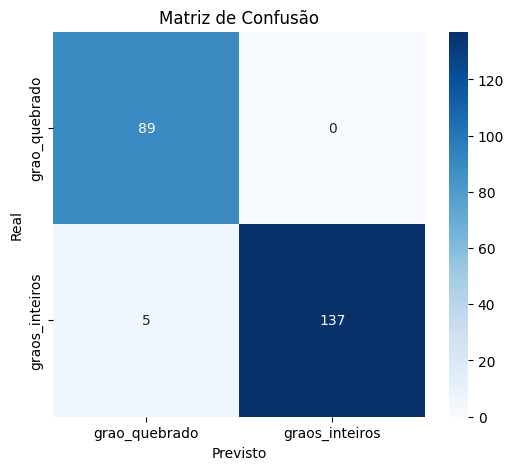

In [47]:
# Reset do gerador
test_generator.reset()

# Previsões (sigmoid → probabilidade entre 0 e 1)
pred_probs = model.predict(test_generator)
pred_classes = (pred_probs > 0.5).astype(int).squeeze()

# Rótulos verdadeiros
true_classes = test_generator.classes

# Nomes das classes (ordem baseada em diretórios)
class_labels = list(test_generator.class_indices.keys())

# Relatório de classificação
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# Matriz de confusão
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


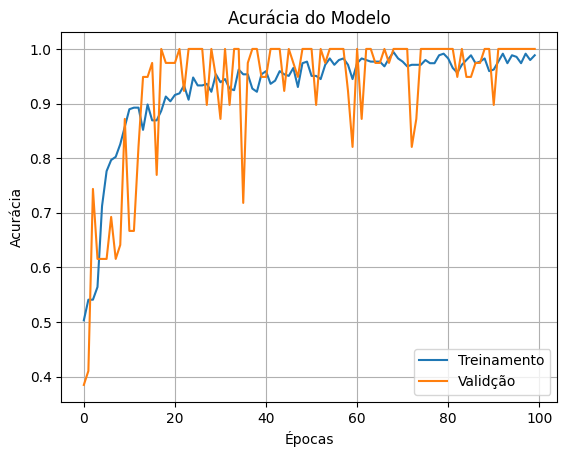

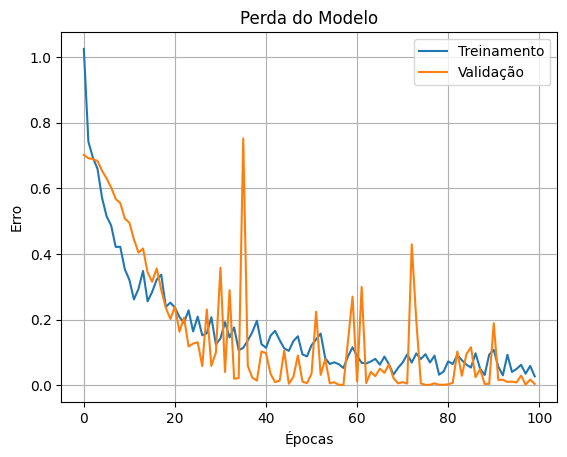

In [48]:
# 6. Traça a precisão do treinamento e da validação ao longo de épocas usando o objeto de histórico.
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validção')
plt.title('Acurácia do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

# 7. Traça a perda de treinamento e validação ao longo de épocas usando o objeto de histórico.
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Erro')
plt.legend()
plt.grid(True)
plt.show()